<a href="https://colab.research.google.com/github/DavideScassola/PML2024/blob/main/Notebooks/03_pyro_basics_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 3: **Pyro** basics exercises

In [ ]:
# !pip install pyro-ppl

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

### Exercise 1

Consider the following model of the delay in getting to the workplace:

$$A\text{(alarm clock did not ring)} \sim Bern(0.1)$$

$$R\text{(heavy rain)} \sim Bern(0.15)$$

$$T\text{(traffic jam delay)} \sim Exponential(\mu = 5 + 10R) \ \ (\text{minutes})$$

$$D\text{(total delay)} \sim N(\mu = T + 30A, \sigma = 5) \ \ (\text{minutes})$$

1. Write the corresponding model in pyro
2. plot the corersponding graphical model
3. Sample 25000 samples from $p(A,R,T,D)$
4. Estimate $p(D)$ from the simulated values
5. Estimate $p(D | A)$ from the simulated values
6. Estimate $p(A | D>30m)$ from the simulated values

Hint: notice that `dist.Exponential` takes the rate as argument and not the mean

#### Solution

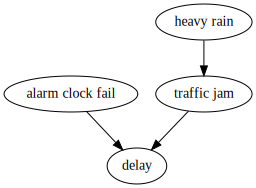

In [2]:
import pandas as pd

# 1: Write the corresponding model in pyro
def model(n: int = 1):
    a = pyro.sample("alarm clock fail", dist.Bernoulli(0.1), sample_shape=(n,))
    r = pyro.sample("heavy rain", dist.Bernoulli(0.15), sample_shape=(n,))
    t = pyro.sample("traffic jam", dist.Exponential(1/(5 + 10 * r)))
    d = pyro.sample("delay", dist.Normal(t + 30 * a, 5))
    return {'A': a, 'R': r, 'T': t, 'D': d}

# 2: plot the corersponding graphical model
pyro.render_model(model)

In [3]:
# 3: Sample 25000 samples from $p(A,R,T,D)$
samples = pd.DataFrame(model(25_000))
samples

,A,R,T,D
0,0.0,1.0,11.890687,5.999184
1,0.0,0.0,3.197040,-2.539282
2,0.0,0.0,3.076787,2.140787
3,0.0,0.0,18.124046,12.070762
4,0.0,0.0,5.155998,4.798436
...,...,...,...,...
24995,1.0,0.0,6.378881,31.246674
24996,0.0,1.0,4.731237,4.127814
24997,0.0,0.0,1.937156,6.683343
24998,0.0,0.0,31.963884,33.066597


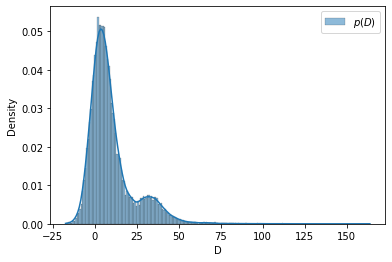

In [4]:
# 4: Find p(D) from the simulated values
_ = sns.histplot(samples['D'], kde=True, stat='density', label='$p(D)$')
_ = plt.legend()

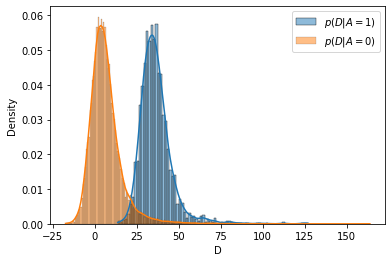

In [5]:
# 5: Find $p(D | A)$ from the simulated values
_ = sns.histplot(samples[samples['A']==1.0]['D'], kde=True, stat='density', label='$p(D|A=1)$')
_ = sns.histplot(samples[samples['A']==0.0]['D'], kde=True, stat='density', label='$p(D|A=0)$')
_ = plt.legend()

In [6]:
# 6: Find $p(A | D>30m)$ from the simulated values
k = 30
p = samples[samples['D']>k]['A'].mean()
print(f'P(A=1 | D>{k}) = {p:.2%}')

P(A=1 | D>30) = 76.36%


### Exercise 2

Do you remember this exercise?

*Yuo are handed a fair coin with probability $0.5$ or an unfair coin (having $P(\text{head})=0.8$) with probability $0.5$. Then you toss it two times, with results $H_1$ and $H_2$.*

*Let's call $C$ the random variable describing if the coin is fair or not.*

Now you can give an approximate answer to the following questions through simulation with pyro:

1. Compute $p(h_1)$
2. Compute $p(c | h_1)$
3. Compute $p(h_2 | h_1)$

#### Solution

### Exercise 3

You have a set of $N$ observations $\text{height}_i$ of height of $N$ individuals all coming from an unknown country and you want to build a model of it. 
A (pretty simplistic) model is:
$$\mu_{male} \sim \mathcal{N}(\text{loc}=177, \text{scale}=5) \text{   (cm)}$$
$$\mu_{female} \sim \mathcal{N}(\text{loc}=164, \text{scale}=5)  \text{   (cm)}$$
$$S_i (\text{sex}) \sim Bern(0.5)$$
$$H_i (\text{height}) \sim \mathcal{N}(  \text{loc}=\mu,   \text{scale}= \frac{ \mu}{40}) \text{ where } \mu = \mu_{male} \text{ if } S_i=\text{male else } \mu_{female}  \text{   (cm)}$$

1. Write the corresponding model in pyro (assuming you actually have some observations).
2. Plot the corresponding graphical model.
3. Fixing $N=10000$, sample from the model, show the sampled values of $\mu_{male}$ and $\mu_{female}$ and plot the histogram of $H_i$. Do it two times (for two different samples).
4. Fixing $N=1$, estimate $p(\text{height})$ by simulation (you can redefine the model if it is simpler for you).
5. Fixing $N=1$, estimate $P(S = \text{male}| \text{height}> 180)$ by simulation.

#### Solution

### Exercise 4

It seems there is a correlation between the average weight of an animal species and its average longevity.

<img src="https://qph.cf2.quoracdn.net/main-qimg-427d1e41011ad526b9b186daf661bb54-pjlq" alt="drawing" width="500"/>

Suppose you have a dataset of $N$ observations $(\text{weight}_i, \text{longevity}_i)$ relative to different species and that you are only intersted in $p(\text{longevity} | \text{weight})$ (so you are not intersted in $p(\text{weight})$).

Given the following linear model:
$$p(\text{longevity} | \text{weight}, \alpha, h, \beta) = \mathcal{N}(\text{longevity}; \text{loc} =  h + \alpha \cdot \text{weight}; \text{scale} = \beta) $$

where

$$p(\alpha) = \mathcal{N}(\alpha; \text{loc} = 0, \text{scale} = 0.15) $$
$$p(h) = \mathcal{N}(h; \text{loc} = 0, \text{scale} = 0.15) $$
$$p(\beta) = Exponential(\beta; \mu = 0.2) $$



where longevity is in $\log_{10}$ years and weight is in $\log_{10}$ grams.

1. Define the model in pyro supposing to have the following observed data and plot the corresponding graphical model.

`observations = [(1.05, -0.3), (3.1, 0.84), (5.17, 2.1)]`

2. Now suppose you don't have any observation, estimate $p(\text{longevity} | \text{weight=100g})$ and $p(\text{longevity} | \text{weight=1000kg})$ by simulation.
3. Now suppose someone fitted a bayesian model given some data, and found that approximately:

    $$p(\alpha) = \mathcal{N}(\alpha; \text{loc} = 0.2, \text{scale} = 0.025) $$
    $$p(h) = \mathcal{N}(h; \text{loc} = 0.2, \text{scale} = 0.02) $$
    $$\beta \approx 0.05 \text{  (so this parameter was not fitted in a bayesian way)}$$

    Given this new knowledge, estimate $p(\text{longevity} | \text{weight=100g})$ and $p(\text{longevity} | \text{weight=1000kg})$ by simulation.

#### Solution